In [ ]:
!pip install rohub

In [54]:
import rohub

rohub.settings.API_URL = "https://rohub2020-rohub.apps.paas-dev.psnc.pl/api/"
rohub.settings.KEYCLOAK_CLIENT_ID = "rohub2020-cli"
rohub.settings.KEYCLOAK_CLIENT_SECRET = "714617a7-87bc-4a88-8682-5f9c2f60337d"
rohub.settings.KEYCLOAK_URL = "https://keycloak-dev.apps.paas-dev.psnc.pl/auth/realms/rohub/protocol/openid-connect/token"
rohub.settings.SPARQL_ENDPOINT = "https://rohub2020-api-virtuoso-route-rohub.apps.paas-dev.psnc.pl/sparql/"

In [ ]:
username = ""
password = ""

rohub.login(username=username, password=password)

Logged successfully as mahdi.jafarkhani@gmail.com.


In [ ]:
result = rohub.ros_delete("801c034a-ec58-41ce-b5b3-4e692f9f893a")
print(result)

In [ ]:
research_areas  = ["Environmental research"]
title  =  "NFDI4ING Model Validation with Snakemake"
description  =  f"Description for {title}"
zip_path = "/Users/mahdi/Downloads/metadata4ing_provenance.zip"
RO  =  rohub.ros_upload(path_to_zip=zip_path)
print(f"Identifier: {RO.identifier}")

In [79]:
ANNOTATION_PREDICATE = "http://schema.org/codeRepository"
ANNOTATION_OBJECT = "https://github.com/BAMresearch/NFDI4IngModelValidationPlatform/tree/main/benchmarks/linear-elastic-plate-with-hole"

In [ ]:
RO  =  rohub.ros_load("b26ad655-c51c-4cf6-a6c0-8ca8a8383bc7")
annotation_json  = [
	{
		"property": ANNOTATION_PREDICATE,
		"value": ANNOTATION_OBJECT
	}
]
add_annotations_result = RO.add_annotations(body_specification_json=annotation_json)

print(add_annotations_result)

Research Object was successfully loaded with id = b26ad655-c51c-4cf6-a6c0-8ca8a8383bc7


In [100]:
UUID_QUERY = f"""
SELECT ?subject 
WHERE {{
  ?subject <{ANNOTATION_PREDICATE}> <{ANNOTATION_OBJECT}> .
}}
"""

In [101]:
result = rohub.query_sparql_endpoint(UUID_QUERY, endpoint_url=rohub.settings.SPARQL_ENDPOINT)

if not result.empty:
    research_object_iri = result.iloc[0]["subject"]
    UUID = research_object_iri.split('/')[-1]
else:
    print("No results found")

No results found


In [102]:
UUID = "b26ad655-c51c-4cf6-a6c0-8ca8a8383bc7"

In [103]:
PROVENANCE_QUERY = f"""
PREFIX schema: <http://schema.org/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX m4i: <http://w3id.org/nfdi4ing/metadata4ing#>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
PREFIX ssn: <http://www.w3.org/ns/ssn/>

SELECT DISTINCT ?value_element_size ?value_max_von_mises_stress_gauss_points ?tool_name
WHERE {{
  # ---- Input UUID ----
  VALUES ?uuid {{ "{UUID}" }}

  # ---- Construct the full Dataset IRI from UUID ----
  BIND(IRI(CONCAT("https://w3id.org/ro-id-dev/", ?uuid)) AS ?dataset)

  # ---- Find which graph contains that dataset ----
  {{
    SELECT ?g WHERE {{
      GRAPH ?g {{ ?dataset a schema:Dataset . }}
    }}
  }}

  # ---- Query the graph found above ----
  GRAPH ?g {{
    ?method a m4i:Method ;
                     m4i:hasParameter ?element_size ;
                     m4i:hasParameter ?element_order ;
                     m4i:hasParameter ?element_degree ;
                     m4i:investigates ?max_von_mises_stress_gauss_points ;
                     ssn:implementedBy  ?tool .

    ?max_von_mises_stress_gauss_points a schema:PropertyValue ;
                                       rdfs:label "max_von_mises_stress_nodes" ;
                                       schema:value ?value_max_von_mises_stress_gauss_points .

    ?element_order a schema:PropertyValue ;
                   rdfs:label "element_order" ;
                   schema:value "1" .

    ?element_degree a schema:PropertyValue ;
                    rdfs:label "element_degree" ;
                    schema:value "1" .

    ?element_size a schema:PropertyValue ;
                  rdfs:label "element_size" ;
                  schema:value ?value_element_size .

    ?tool a schema:SoftwareApplication ;
          rdfs:label ?tool_name .

    FILTER (LCASE(str(?tool_name)) = "fenics-dolfinx" || LCASE(str(?tool_name)) = "kratosmultiphysics-all")
  }}
}}
ORDER BY ?tool_name xsd:decimal(?value_element_size)
"""

In [104]:
result = rohub.query_sparql_endpoint(PROVENANCE_QUERY, endpoint_url=rohub.settings.SPARQL_ENDPOINT)

In [105]:
from tabulate import tabulate

table_data = []

headers = [
    "element-size",
    "max-mises-stress",
    "Tool Name"
]

if not result.empty:
    table_data = [
        [
            float(row["value_element_size"]),                   # element-size
            float(row["value_max_von_mises_stress_gauss_points"]),  # max-mises-stress
            row["tool_name"],                                   # Tool Name
        ]
        for _, row in result.iterrows()
    ]

    headers = [
        "element-size",
        "max-mises-stress",
        "Tool Name"
    ]

    # Choose your sort key depending on which column you want to sort by
    # Example: sort by element-size
    sort_key = 0   # index in table_data row → 0: element-size, 1: max-mises-stress, 2: Tool Name

    table_data.sort(key=lambda row: row[sort_key], reverse=False)

    print(tabulate(table_data, headers=headers))

else:
    print("No results found")

No results found


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


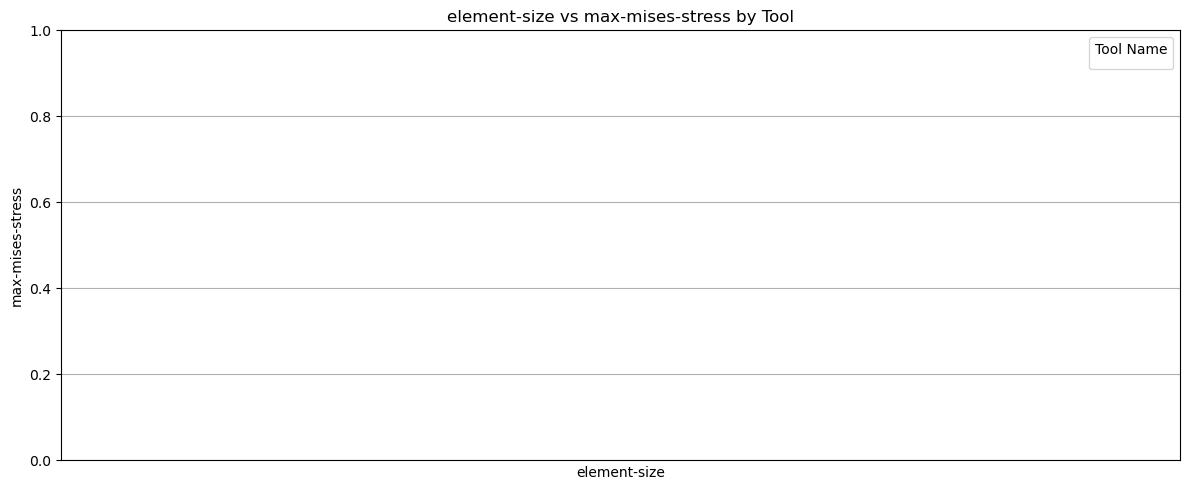

In [106]:
import matplotlib.pyplot as plt
from collections import defaultdict

idx_element_size = headers.index("element-size")
idx_stress = headers.index("max-mises-stress")
idx_tool = headers.index("Tool Name")

grouped_data = defaultdict(list)
x_tick_set = set()

for row in table_data:
    tool = row[idx_tool]
    x = float(row[idx_element_size])
    y = float(row[idx_stress])
    grouped_data[tool].append((x, y))
    x_tick_set.add(x)

# Sort x-tick labels
x_ticks = sorted(x_tick_set)

plt.figure(figsize=(12, 5))
for tool, values in grouped_data.items():
    values.sort()
    x_vals, y_vals = zip(*values)
    plt.plot(x_vals, y_vals, marker='o', linestyle='-', label=tool)

plt.xlabel("element-size")
plt.ylabel("max-mises-stress")
plt.title("element-size vs max-mises-stress by Tool")
plt.legend(title="Tool Name")
plt.grid(True)

# Set exact x-axis tick labels without rounding
plt.xticks(ticks=x_ticks, labels=[str(x) for x in x_ticks], rotation=45)

plt.tight_layout()
plt.show()
